In [1]:
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import tarfile
import os
from PIL import Image

from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchvision import datasets, models, transforms
from torchsummary import summary
from typing import Callable, Dict, List, Tuple, Union
from torch.optim import lr_scheduler
# from torch.utils.tensorboard import SummaryWriter
# import skimage

import clip #importing clip model

print("Torch version:", torch.__version__)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 2.0.0+cu117


In [2]:
device = "cpu"
if torch.cuda.is_available:
  print('cuda available')
  device = torch.device("cuda:0")
else:
  print('Please set GPU via Edit -> Notebook Settings.')

cuda available


In [3]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
# 왜 vit32 사용했는지

model, preprocess = clip.load("ViT-B/32",jit=False) #loading the CLIP model based on ViT
model.cuda().eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [5]:
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

In [6]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

class NormalizeInverse(torchvision.transforms.Normalize):
    def __init__(self, mean: List[float], std: List[float]) -> None:
        """Reconstructs the images in the input domain by inverting 
        the normalization transformation.

        Args:
            mean: the mean used to normalize the images.
            std: the standard deviation used to normalize the images.
        """
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

def show_grid(dataset: torchvision.datasets.ImageFolder, 
              process: Callable = None) -> None:
    """Shows a grid with random images taken from the dataset.

    Args:
        dataset: the dataset containing the images.
        process: a function to apply on the images before showing them.        
    """
    fig = plt.figure(figsize=(15, 5))
    indices_random = np.random.randint(len(dataset), size=10)
    #indices_random= [x for x in range(8)]

    for count, idx in enumerate(indices_random):
        fig.add_subplot(2, 5, count + 1)
        title = dataset.classes[dataset[idx][1]]
        plt.title(title)
        image_processed = process(dataset[idx][0]) if process is not None else dataset[idx][0]
        plt.imshow(transforms.ToPILImage()(image_processed))
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

denormalize = NormalizeInverse(mean, std)

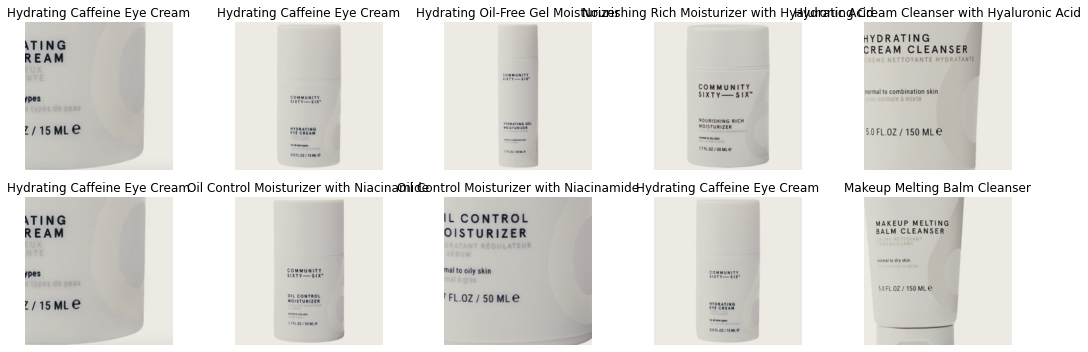

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []  # (path_to_sample, class_index) tuple 리스트를 담는 리스트
        self.classes = []  # 클래스 이름 리스트

        # root 아래의 하위 디렉토리와 파일들을 탐색하여 (path_to_sample, class_index) tuple을 samples 리스트에 추가
        for class_index, class_name in enumerate(os.listdir(root)):
            class_dir = os.path.join(root, class_name)
            if os.path.isdir(class_dir):
                self.classes.append(class_name)
                for sample_name in os.listdir(class_dir):
                    sample_path = os.path.join(class_dir, sample_name)
                    self.samples.append((sample_path, class_index))

    def __getitem__(self, index):
        path, target = self.samples[index]
        with open(path, 'rb') as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

    def __len__(self):
        return len(self.samples)

data_set = CustomDataset('/workspace/data/', transform=preprocess)
train_set = CustomDataset('/workspace/data/train/', transform=preprocess)
test_set = CustomDataset('/workspace/data/test/', transform=preprocess)
show_grid(train_set, process=denormalize)

## Zero shot

In [8]:
# Test 이미지, 라벨
image_input = torch.tensor(np.stack([test_set[x][0] for x in range(len(test_set))])).cuda()
labels = torch.tensor(np.stack([test_set[x][1] for x in range(len(test_set))]))
print(labels)
with torch.no_grad():
    image_features = model.encode_image(image_input).float()

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])


In [9]:
# text_descriptions = [f"The name of product is {label} and it is written in black on the package. All the packages are white colour" for label in train_set.classes]
text_descriptions = [f"a photo of {label}" for label in train_set.classes]

# text_descriptions = ["This gentle, non-foaming cream cleanser gently removes dirt, oil, and makeup without stripping the skin of its natural moisture. Formulated with hyaluronic acid and a blend of nourishing ingredients, it leaves the skin feeling hydrated and refreshed. Suitable for all skin types, this cleanser is perfect for daily use and helps to maintain a healthy, radiant complexion.",
#                     "This is a hydrating oil-free gel moisturizer, which is designed to provide lightweight hydration to the skin without leaving a greasy residue. It is formulated with a blend of ingredients, including hyaluronic acid and aloe vera, to help soothe and nourish the skin.",
#                      "Everyday Mineral Moisturizer SPF 30 Sunscreen is a facial moisturizer that contains natural minerals to protect your skin from the sun's harmful UV rays while providing hydration. This formula is free of harsh chemicals, making it suitable for sensitive skin types. It is designed to be worn daily to keep your skin nourished and protected.",
#                      "This oil-free moisturizer is formulated with niacinamide to help regulate oil production and reduce the appearance of pores, while also providing lightweight hydration. Ideal for oily or combination skin types, it absorbs quickly without leaving a greasy residue.",
#                      "Retinol Resurfacing Night Moisturizer: A moisturizer that contains retinol and is designed for nighttime use to improve skin texture and reduce fine lines and wrinkles.",
#                      "The Nourishing Rich Moisturizer with Hyaluronic Acid is a hydrating cream that helps to moisturize and nourish dry and dehydrated skin. It contains hyaluronic acid which helps to lock in moisture and improve the skin's natural barrier, while the rich formula helps to soothe and protect the skin.",
#                      "The Hydrating Caffeine Eye Cream is designed to reduce puffiness and dark circles around the eyes while providing hydration to the delicate skin in that area. It contains caffeine to help de-puff and brighten the under-eye area, along with hyaluronic acid and nourishing oils to moisturize and improve skin texture.",
#                      "A nourishing Makeup Melting Balm Cleanser that gently dissolves makeup, dirt, and impurities from the skin while leaving it hydrated and moisturized."
#                     ]


# print(text_descriptions)

# text descriptions 활용
text_tokens_ensembled = clip.tokenize(text_descriptions).cuda()
# 클래스 이름 활용
text_tokens = clip.tokenize(train_set.classes).cuda()

In [10]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features_ensembled = model.encode_text(text_tokens_ensembled).float()
    text_features_ensembled /= text_features_ensembled.norm(dim=-1, keepdim=True)
#the 100.0 works as temperature parameter, raising the softmax confidence 
text_probs_notens = (100.0 * image_features @ text_features.T).softmax(dim=-1)
text_probs = ( 100.0 * image_features @ text_features_ensembled.T).softmax(dim=-1)

top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)
top_probs_n, top_labels_n = text_probs_notens.cpu().topk(5, dim=-1)

In [11]:
correct_labels = 0
correct_labels_not = 0
for index, prediction in enumerate(top_labels):
  if prediction[0]==labels[index]:
    correct_labels=correct_labels+1
    print(labels[index])
for index, prediction in enumerate(top_labels_n):
  if prediction[0]==labels[index]:
    correct_labels_not=correct_labels_not+1
    print(labels[index])
print("The overall accuracy for the CLIP Zero shot model with ensembling is: {}".format((correct_labels/len(top_labels))))
print("The overall accuracy for the CLIP Zero shot model without ensembling is: {}".format((correct_labels_not/len(top_labels_n))))

print(correct_labels)
print(correct_labels_not)

tensor(0)
tensor(0)
tensor(1)
tensor(1)
The overall accuracy for the CLIP Zero shot model with ensembling is: 0.3
The overall accuracy for the CLIP Zero shot model without ensembling is: 0.1
3
1


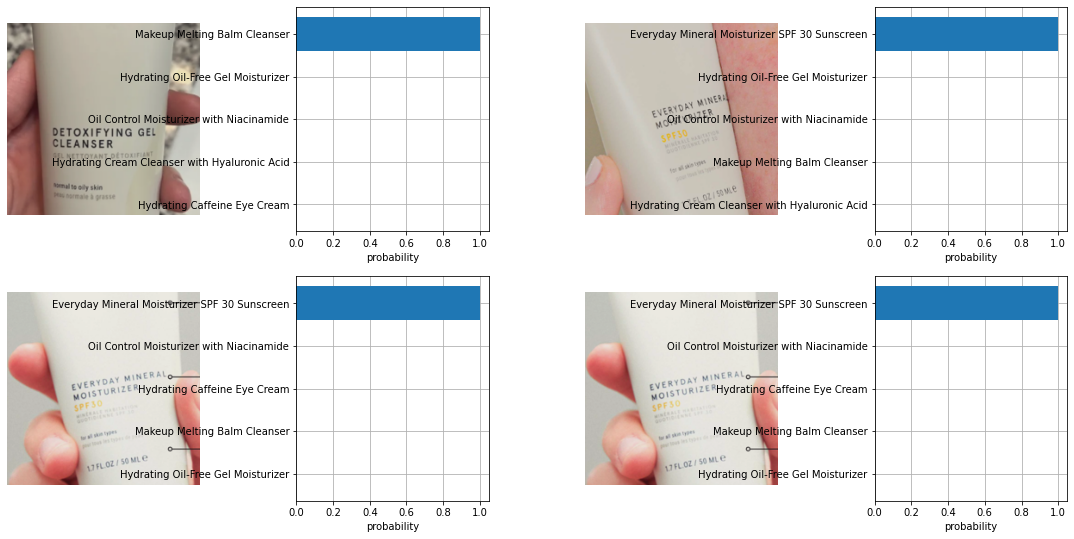

In [12]:
plt.figure(figsize=(19, 19))
#taking random index for random sampling
random_index = np.random.randint(len(image_input), size=4)
image_input_sample = [(image_input[x],x) for x in random_index] 
for i, image in enumerate(image_input_sample):
    plt.subplot(len(image_input_sample), 4, 2 * i + 1)
    #denormalizing the image and transforming to PIL image
    image_processed = denormalize(image[0].cpu())
    plt.imshow(transforms.ToPILImage()(image_processed))

    plt.axis("off")

    plt.subplot(len(image_input_sample), 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[image[1]])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [train_set.classes[index] for index in top_labels[image[1]].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

## Few shot

In [13]:
NUM_CLASSES = len(train_set.classes)
print(f'Num of class is : {NUM_CLASSES}')

linear_probe_model = nn.Sequential(
    model.visual,
    nn.Linear(512, NUM_CLASSES)
)
linear_probe_model.eval()
linear_probe_model.to(device)

Num of class is : 8


Sequential(
  (0): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
         

In [14]:
# Accuracy
def get_correct_samples(scores: torch.Tensor, labels: torch.Tensor) -> int:
    """Gets the number of correctly classified examples.

    Args:
        scores: the scores predicted with the network.
        labels: the class labels.

    Returns: 
        the number of correct samples.
    """
    classes_predicted = torch.argmax(scores, 1)
    return (classes_predicted == labels).sum().item()

In [15]:
# Train one epoch
def train(model: nn.Module,
          train_loader: utils.data.DataLoader,
          device: torch.device,          
          optimizer: torch.optim,
          criterion: Callable[[torch.Tensor, torch.Tensor], float],
          log_interval: int,
          epoch: int) -> Tuple[float, float]:
    """Trains a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.        
        optimizer: the optimizer to use to train the model.
        criterion: the loss to optimize.
        log_interval: the log interval.
        epoch: the number of the current epoch.

    Returns:
        the cross entropy Loss value on the training data.
        the accuracy on the training data.
    """    
    correct = 0
    samples_train = 0
    loss_train = 0
    size_ds_train = len(train_loader.dataset)
    num_batches = len(train_loader)

    model.train()
    for idx_batch, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        scores = model(images)

        loss = criterion(scores, labels)
        loss_train += loss.item() * len(images)
        samples_train += len(images)        

        loss.backward()
        optimizer.step()
        correct += get_correct_samples(scores, labels)

        if log_interval > 0:
            if idx_batch % log_interval == 0:
                running_loss = loss_train / samples_train
                global_step = idx_batch + (epoch * num_batches) 
#                 writer.add_scalar('Metrics/Loss_Train_IT', running_loss, global_step)
                # Visualize images on tensorboard
                indices_random = torch.randperm(images.size(0))[:4]                
#                 writer.add_images('Samples/Train', denormalize(images[indices_random]), global_step)
                
    loss_train /= samples_train
    accuracy_training = 100. * correct / samples_train
    return loss_train, accuracy_training

In [16]:
# Validate one epoch
def validate(model: nn.Module,
             data_loader: utils.data.DataLoader,
             device: torch.device,
             criterion: Callable[[torch.Tensor, torch.Tensor], float]) -> Tuple[float, float]:
    """Evaluates the model.

    Args:
        model: the model to evalaute.
        data_loader: the data loader containing the validation or test data.
        device: the device to use to evaluate the model.
        criterion: the loss function.

    Returns:
        the loss value on the validation data.
        the accuracy on the validation data.
    """
    correct = 0
    samples_val = 0
    loss_val = 0.
    model = model.eval()
    with torch.no_grad():
        for idx_batch, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)
            scores = model(images)

            loss = criterion(scores, labels)
            loss_val += loss.item() * len(images)
            samples_val += len(images)
            correct += get_correct_samples(scores, labels)

    loss_val /= samples_val
    accuracy = 100. * correct / samples_val
    return loss_val, accuracy

In [17]:
def training_loop(num_epochs: int,
                  optimizer: torch.optim, 
                  lr_scheduler: torch.optim.lr_scheduler,
                  log_interval: int, 
                  model: nn.Module, 
                  loader_train: utils.data.DataLoader, 
                  loader_val: utils.data.DataLoader, 
                  verbose: bool=True) -> Dict:
    """Executes the training loop.
    
        Args:
            writer: the summary writer for tensorboard.
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            lr_scheduler: the scheduler for the learning rate.
            log_interval: intervall to print on tensorboard.
            model: the mode to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            verbose: if true print the value of loss.

        Returns:  
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch.
            the values for the train accuracy for each epoch.
            the values for the validation accuracy for each epoch.
            the time of execution in seconds for the entire loop.
    """
    criterion = nn.CrossEntropyLoss()    
    loop_start = timer()

    losses_values = []
    train_acc_values = []
    val_acc_values = []
    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        loss_train, accuracy_train = train(model, loader_train, device, 
                                           optimizer, criterion, log_interval, 
                                           epoch)
        loss_val, accuracy_val = validate(model, loader_val, device, criterion)
        time_end = timer()

        losses_values.append(loss_train)
        train_acc_values.append(accuracy_train)
        val_acc_values.append(accuracy_val)
        
        lr = optimizer.param_groups[0]['lr']
        
        if verbose:            
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                  f' Accuracy: Train = [{accuracy_train:.2f}%] - Val = [{accuracy_val:.2f}%] '
                  f' Time one epoch (s): {(time_end - time_start):.4f} ')
        
        # Increases the internal counter
        if lr_scheduler:            
            lr_scheduler.step()            
    
    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}')
    
    return {'loss_values': losses_values,
            'train_acc_values': train_acc_values,
            'val_acc_values': val_acc_values,
            'time': time_loop}
     

In [18]:
num_workers = 4
size_batch = 64

loader_train = torch.utils.data.DataLoader(train_set, batch_size=size_batch, 
                                           shuffle=True, 
                                           pin_memory=True, # speed-up CPU-GPU transfer
                                           num_workers=num_workers)
                                           
loader_val = torch.utils.data.DataLoader(test_set, batch_size=size_batch, 
                                         shuffle=False,
                                         num_workers=num_workers)

In [19]:
def execute(name_train: str, network: nn.Module, starting_lr: float, 
            num_epochs: int, 
            data_loader_train: torch.utils.data.DataLoader,
            data_loader_val: torch.utils.data.DataLoader) -> None:
    """Executes the training loop.

    Args:
        name_train: the name for the log subfolder.
        network: the network to train.
        starting_lr: the staring learning rate.
        num_epochs: the number of epochs.
        data_loader_train: the data loader with training data.
        data_loader_val: the data loader with validation data.
    """
    # Visualization 
    log_interval = 20
    log_dir = os.path.join("logs", name_train)
    
    # Optimization
    
    network.to(torch.float32)
    
    optimizer = optim.SGD(network.parameters(), lr=starting_lr, momentum=0.9, 
                          weight_decay=0.0001)
    
    



    # Learning Rate schedule: decays the learning rate by a factor of `gamma` 
    # every `step_size` epochs
    #scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    scheduler = None

    statistics = training_loop(num_epochs, optimizer, scheduler, 
                               log_interval, network, data_loader_train, 
                               data_loader_val)
    
    best_epoch = np.argmax(statistics['val_acc_values']) + 1
    best_accuracy = statistics['val_acc_values'][best_epoch - 1]

    print(f'Best val accuracy: {best_accuracy:.2f} epoch: {best_epoch}.')
     


In [20]:
def set_requires_grad_for_layer(layer: torch.nn.Module, train: bool) -> None:
    """Sets the attribute requires_grad to True or False for each parameter.
        
        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train

In [21]:
#freezing parameters for feature extraction
set_requires_grad_for_layer(linear_probe_model[0], False)
set_requires_grad_for_layer(linear_probe_model[1], True)

In [22]:
name_train = "CLIP_feature_extractor"
lr = 0.001
num_epochs = 200
execute(name_train, linear_probe_model, lr, num_epochs, loader_train, loader_val)

Epoch: 1  Lr: 0.00100000  Loss: Train = [2.0976] - Val = [2.1769]  Accuracy: Train = [13.33%] - Val = [0.00%]  Time one epoch (s): 1.4105 
Epoch: 2  Lr: 0.00100000  Loss: Train = [2.0958] - Val = [2.1745]  Accuracy: Train = [13.33%] - Val = [0.00%]  Time one epoch (s): 1.4463 
Epoch: 3  Lr: 0.00100000  Loss: Train = [2.0923] - Val = [2.1711]  Accuracy: Train = [13.33%] - Val = [0.00%]  Time one epoch (s): 1.3945 
Epoch: 4  Lr: 0.00100000  Loss: Train = [2.0873] - Val = [2.1669]  Accuracy: Train = [13.33%] - Val = [0.00%]  Time one epoch (s): 1.3691 
Epoch: 5  Lr: 0.00100000  Loss: Train = [2.0812] - Val = [2.1621]  Accuracy: Train = [13.33%] - Val = [0.00%]  Time one epoch (s): 1.3762 
Epoch: 6  Lr: 0.00100000  Loss: Train = [2.0740] - Val = [2.1567]  Accuracy: Train = [13.33%] - Val = [0.00%]  Time one epoch (s): 1.3871 
Epoch: 7  Lr: 0.00100000  Loss: Train = [2.0659] - Val = [2.1511]  Accuracy: Train = [13.33%] - Val = [0.00%]  Time one epoch (s): 1.3465 
Epoch: 8  Lr: 0.00100000  L